# FIFA
This model is in progress...

## Description
This is a simple feed forward network for fifa dataset
    https://www.kaggle.com/karangadiya/fifa19
    
The best formulated task is to determine market value of a player given the other data.

# Imports

In [47]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from models.mlp import FeedForwardNetwork
from utils.loading import Loader
from utils.trainer import Trainer

tf.enable_eager_execution()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preprocess data

In [120]:
def height_conversion(feet_and_inches):
    feet, inches = feet_and_inches.split("'")
    return float(feet) * 30.48 + float(inches) * 2.54

def weight_conversion(lbs):
    lbs = lbs[:-3]
    lbs = float(lbs)
    return lbs * 0.45359237

def value_conversion(val_str):
    if val_str.startswith("€"):
        val_str = val_str[1:]
    if val_str.endswith("M"):
        val_str = val_str[:-1]
        return float(val_str)
    elif val_str.endswith("K"):
        val_str = val_str[:-1]
        return float(val_str) / 1000.0
    else:
        return float(val_str)

In [141]:
loader = Loader('datasets/fifa.csv')
features = ['Age', 'Height', 'Weight', 'Agility', 'Balance', 'Strength', 'Stamina', 'Aggression', 'Reactions', 'Vision']
target_feature = 'Value'
loader.set_features(features + [target_feature])
loader.apply('Height', height_conversion)
loader.apply('Weight', weight_conversion)
loader.apply('Value', value_conversion)

# Explore data

   Age  Height     Weight  Agility  Balance  Strength  Stamina  Aggression  \
0   31  170.18  72.121187     91.0     95.0      59.0     72.0        48.0   
1   33  187.96  83.007404     87.0     70.0      79.0     88.0        63.0   
2   26  175.26  68.038855     96.0     84.0      49.0     81.0        56.0   
3   27  193.04  76.203518     60.0     43.0      64.0     43.0        38.0   
4   27  180.34  69.853225     79.0     77.0      75.0     90.0        76.0   

   Reactions  Vision  Value  
0       95.0    94.0  110.5  
1       96.0    82.0   77.0  
2       94.0    87.0  118.5  
3       90.0    68.0   72.0  
4       91.0    94.0  102.0  


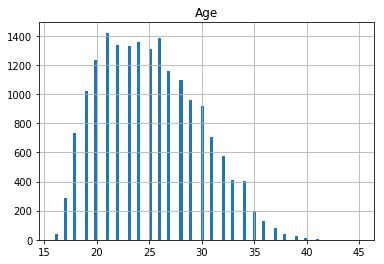

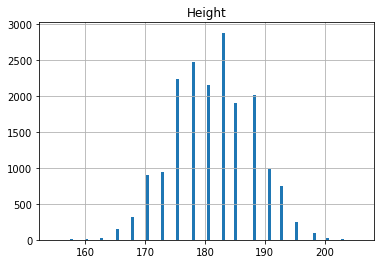

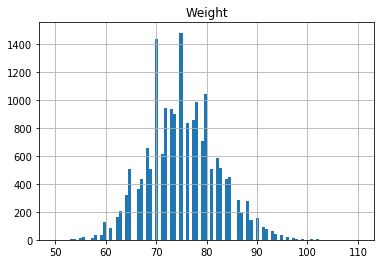

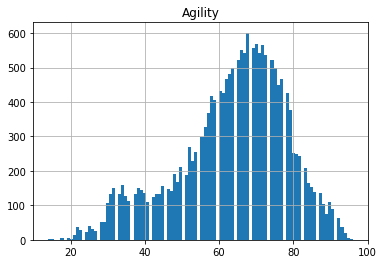

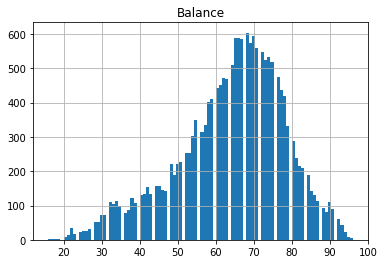

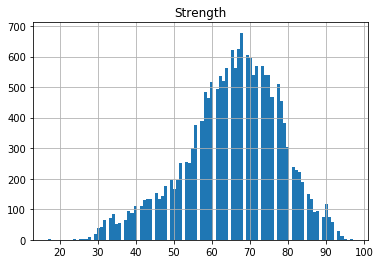

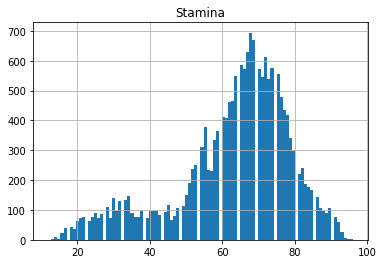

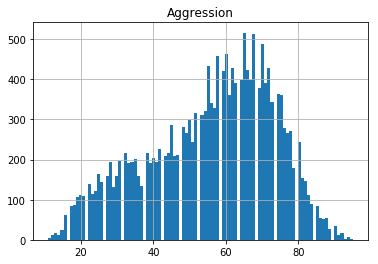

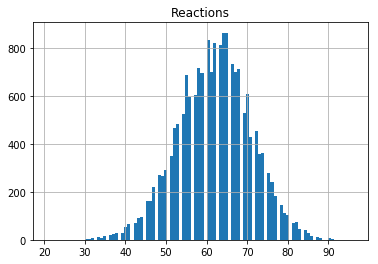

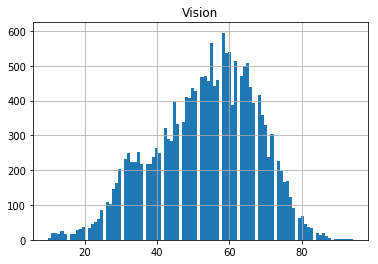

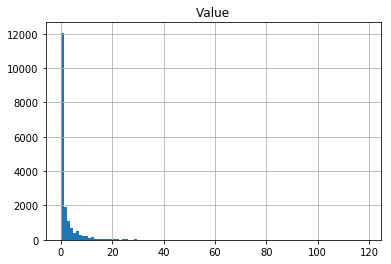

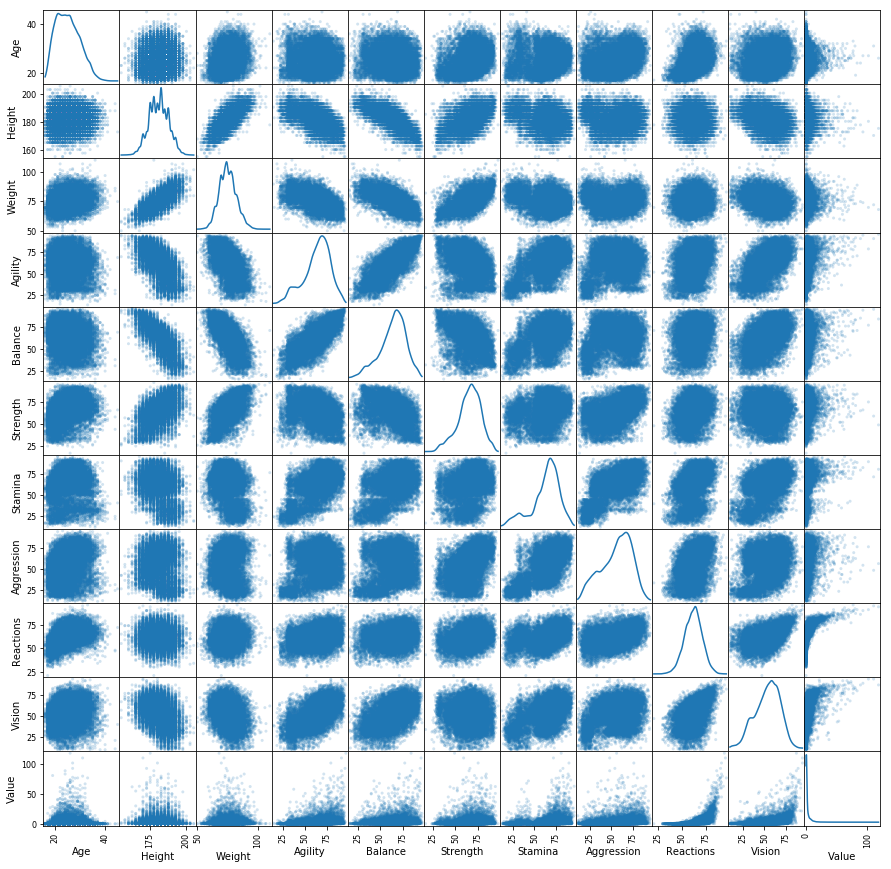

In [142]:
data = loader.get_data()
print(data.head())
for f in features + [target_feature]:
    data.hist(column=f, bins=100)
from pandas.plotting import scatter_matrix
scatter_matrix(data, alpha=0.2, figsize=(15, 15), diagonal='kde');

# Train model

In [143]:
from tensorflow.losses import Reduction

def compute_accuracy(logits, targets):
    return tf.losses.mean_squared_error(targets, logits, reduction=Reduction.MEAN)

def compute_loss(targets, logits):
    return tf.losses.mean_squared_error(targets, logits, reduction=Reduction.MEAN)

In [157]:
EPOCHS = 20
LEARNING_RATE = 0.002
BATCH_SIZE = 64
TRAIN_FRACTION = 0.8

# Create data split
train_data, test_data = loader.get_data_split(TRAIN_FRACTION, target_name=target_feature)

# Create model and optimizer
model = FeedForwardNetwork(units=[32, 32, 32], 
                           use_sigmoid=False, 
                           use_bn=True,
                           l2_weight_decay=0.01)
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)

# Train
trainer = Trainer(model, optimizer, train_data, test_data, compute_loss, compute_accuracy)
train_losses, train_accs, test_losses, test_accs = trainer.train(EPOCHS, BATCH_SIZE)

Epoch 01 - Train[Loss=14.195, Metric=13.790], Test[Loss=9.484, Metric=9.083]
Epoch 02 - Train[Loss=10.635, Metric=10.236], Test[Loss=7.588, Metric=7.189]
Epoch 03 - Train[Loss=9.742, Metric=9.342], Test[Loss=7.058, Metric=6.657]
Epoch 04 - Train[Loss=9.133, Metric=8.728], Test[Loss=6.661, Metric=6.254]
Epoch 05 - Train[Loss=8.695, Metric=8.285], Test[Loss=6.581, Metric=6.168]
Epoch 06 - Train[Loss=8.330, Metric=7.914], Test[Loss=6.537, Metric=6.118]
Epoch 07 - Train[Loss=8.078, Metric=7.656], Test[Loss=6.648, Metric=6.222]
Epoch 08 - Train[Loss=7.862, Metric=7.433], Test[Loss=6.370, Metric=5.938]
Epoch 09 - Train[Loss=7.670, Metric=7.236], Test[Loss=6.251, Metric=5.813]
Epoch 10 - Train[Loss=7.490, Metric=7.049], Test[Loss=6.340, Metric=5.896]
Epoch 11 - Train[Loss=7.335, Metric=6.888], Test[Loss=6.475, Metric=6.025]
Epoch 12 - Train[Loss=7.162, Metric=6.709], Test[Loss=6.196, Metric=5.740]
Epoch 13 - Train[Loss=7.039, Metric=6.580], Test[Loss=5.966, Metric=5.505]
Epoch 14 - Train[Loss

In [158]:
# Try a few
iterator = test_data.make_one_shot_iterator()
for i, (inputs, label) in enumerate(iterator):
    inputs = tf.reshape(inputs, (1, *inputs.shape))
    pred = model(inputs, training=False)
    pred = tf.contrib.layers.flatten(pred)[0,0]
    print("Prediction: {:.3f}, Label: {:.3f}".format(pred, label[0]))
    if i > 10:
        break

Prediction: 59.268, Label: 72.000
Prediction: 86.362, Label: 93.000
Prediction: 25.870, Label: 44.000
Prediction: 62.547, Label: 78.000
Prediction: 39.493, Label: 58.000
Prediction: 56.355, Label: 64.500
Prediction: 20.310, Label: 36.000
Prediction: 28.506, Label: 30.000
Prediction: 50.266, Label: 64.500
Prediction: 30.922, Label: 30.500
Prediction: 11.742, Label: 38.000
Prediction: 29.238, Label: 55.000


# Plot results

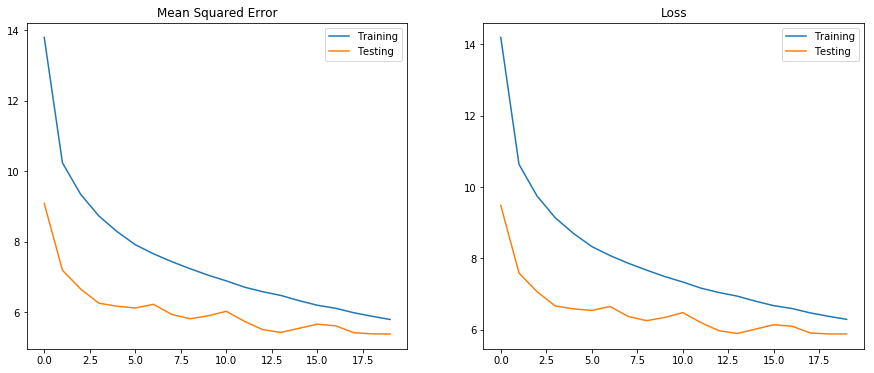

In [159]:
_, (ax1, ax2) = plt.subplots(figsize=(15, 6), nrows=1, ncols=2)
ax1.plot(train_accs)
ax1.plot(test_accs)
ax1.set_title("Mean Squared Error")
ax1.legend(['Training', 'Testing'])
ax2.plot(train_losses)
ax2.plot(test_losses)
ax2.set_title("Loss")
ax2.legend(['Training', 'Testing'])
plt.show()